# 3章　確率的勾配降下法

正則化・正規化に関する議論はモデルとまとめて議論する必要があるので、最適化のみ議論。

教科書の中では、勾配降下法とその変種たちについて議論があった。

ここでは、最適化の文脈でよく使われるテスト関数を使って、最適化方法の特徴を洗い出す。

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import japanize_matplotlib

import sys
sys.path.append('../src')
import objective as obj

In [2]:
def run_optimization(optimizer, f, x, max_iter=3000):
    path = np.empty((max_iter + 1, 2))
    path[0, :] = x.detach().numpy()
    for i in range(max_iter):
        # optimization
        optimizer.zero_grad()
        y = f(x)
        y.backward()
        #torch.nn.utils.clip_grad_norm_(x, 1.0)
        # 更新する。
        optimizer.step()

        path[i+1, :] = x.detach().numpy()

    return path

In [3]:
def plot_history(func_name, functions, history_dict, min_dict, initials, start=-5.0, stop=5.0, elev=45, azim=90, plot_optim_name=None):

    f = functions[func_name]
    history_res = history_dict[func_name]
    minimum_res = min_dict[func_name]
    # グリッドの用意
    grid = np.arange(start=start, stop=stop, step=0.1)
    grid_size = len(grid)
    x1 = torch.Tensor(grid)
    x2 = torch.Tensor(grid)

    # グリッドポイントの値を作成
    xs = torch.cartesian_prod(x1, x2)
    x1, x2 = torch.meshgrid(x1, x2)
    ys = f(xs.T).reshape(grid_size, grid_size)

    # 勾配のベクトル図を作成する。
    fig = plt.figure(figsize=(14, 6))
    fig.suptitle(f'{func_name}: optimization', fontsize=16)
    ax1 = fig.add_subplot(121)
    ax1.set_title("Contour")
    ax1.set_xticks(np.arange(start, stop, 2))
    ax1.set_yticks(np.arange(start, stop, 2))
    ax1.set_xlabel("$x$", fontsize=15)
    ax1.set_ylabel("$y$", fontsize=15)
    ax1.grid()

    if plot_optim_name is None:
        for (optim_name, history) in history_res.items():
            ax1.plot(history[:, 0], history[:, 1], alpha=0.5, label=optim_name, linestyle="--")
    else:
        history = history_res[plot_optim_name]
        ax1.plot(history[:, 0],
                 history[:, 1],
                 alpha=0.5,
                 label=plot_optim_name,
                 linestyle="--")
        
    ax1.scatter([initials[0]],
             [initials[1]],
             label='starting point',
             color="blue")
    ax1.scatter([minimum_res[0]],
             [minimum_res[1]],
             label='global minimum',
             color="red")

    contours = ax1.contour(x1, x2, ys, levels=20)
    ax1.clabel(contours, inline=1, fontsize=10, fmt="%.2f")
    ax1.legend()

    # グラフを作成する。
    ax2 = fig.add_subplot(122, projection="3d")
    ax2.view_init(elev=elev, azim=azim)
    ax2.set_title("Surface")
    ax2.set_xlabel("$x$", fontsize=15)
    ax2.set_ylabel("$y$", fontsize=15)
    ax2.set_zlabel("$z$", fontsize=15)

    if plot_optim_name is None:
        for (optim_name, history) in history_res.items():
            y_hist = f(torch.Tensor(history.T)).detach().numpy()
            ax2.plot3D(history[:, 0], history[:, 1], y_hist, alpha=0.3, label=optim_name,
                     linestyle="--")
    else:
        history = history_res[plot_optim_name]
        y_hist = f(torch.Tensor(history.T)).detach().numpy()
        ax2.plot3D(history[:, 0], history[:, 1], y_hist, alpha=0.3, label=plot_optim_name,
                     linestyle="--")

    ax2.plot_surface(x1, x2, ys, alpha=0.2, cmap='viridis')
    ax2.legend()
    plt.tight_layout()
    plt.show()

In [4]:
# テスト関数群の準備
functions = {}
functions['Sphere'] = obj.sphere

functions['booth'] = obj.booth
functions['rosenbrock'] = obj.rosenbrock
functions['ackley'] = obj.ackley
functions['easom'] = obj.easom


# 最小値の定義
minimums={}
minimums['Sphere'] = [0, 0]
minimums['booth'] = [1, 3]
minimums['rosenbrock'] = [1, 1]
minimums['ackley']=[0, 0]
minimums['easom'] = [np.pi, np.pi]

## 検証用設定の準備
lr =0.01

initials = [0.0, -3.0]

# 最適化アルゴリズムの定義
optimizers = {}
optimizers['SGD'] = optim.SGD
optimizers['momentum'] = optim.SGD
optimizers['AdaGrad'] = optim.Adagrad
optimizers['RMSProp'] = optim.RMSprop
optimizers['Adadelta'] = optim.Adadelta
optimizers['Adam'] = optim.Adam


In [5]:
# 最適化の実施
history_res = {}
for (func_name ,f) in functions.items():
    history_res[func_name] = {}
    for (optim_name, optim_class) in optimizers.items():
        x_init = torch.tensor(initials, requires_grad=True)
        if optim_name == 'momentum':
            optimizer = optim_class([x_init], lr=lr, momentum=0.4)
        elif optim_name == 'Adadelta':
            optimizer = optim_class([x_init])
        else:
            optimizer = optim_class([x_init], lr=lr)
            


        history_res[func_name][optim_name] = run_optimization(optimizer, f,
                                                       x_init)


/Users/tokuma/GitFolder/MLP_DL/venv/lib/python3.9/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


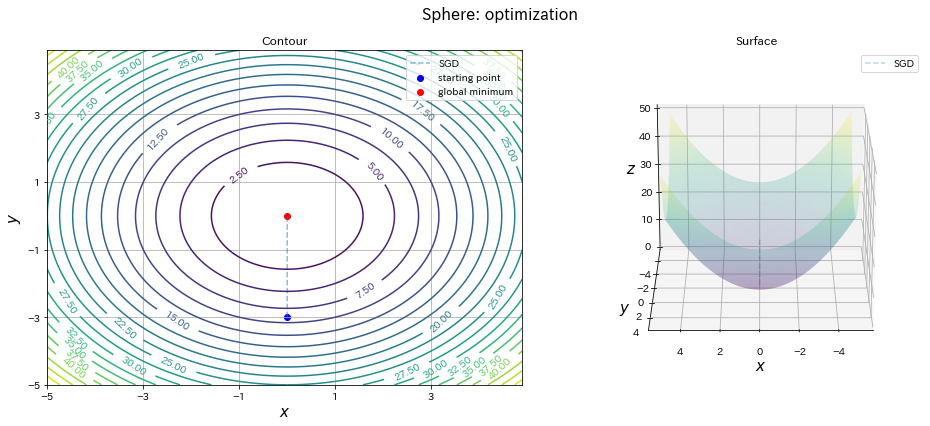

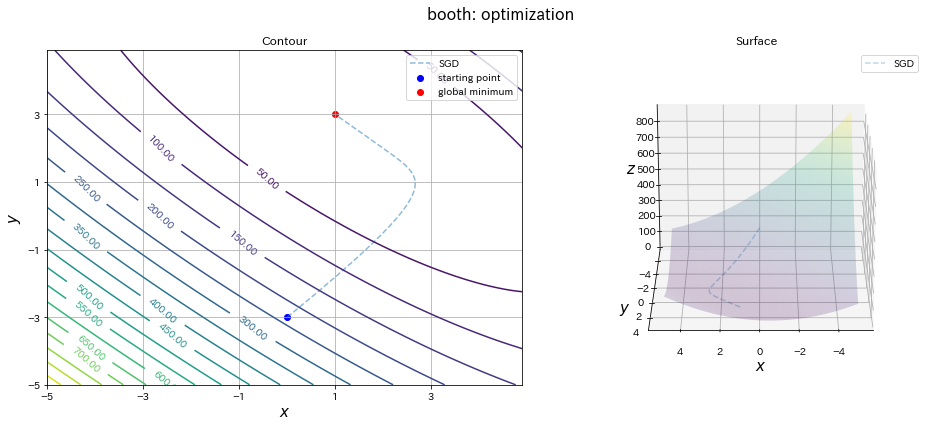

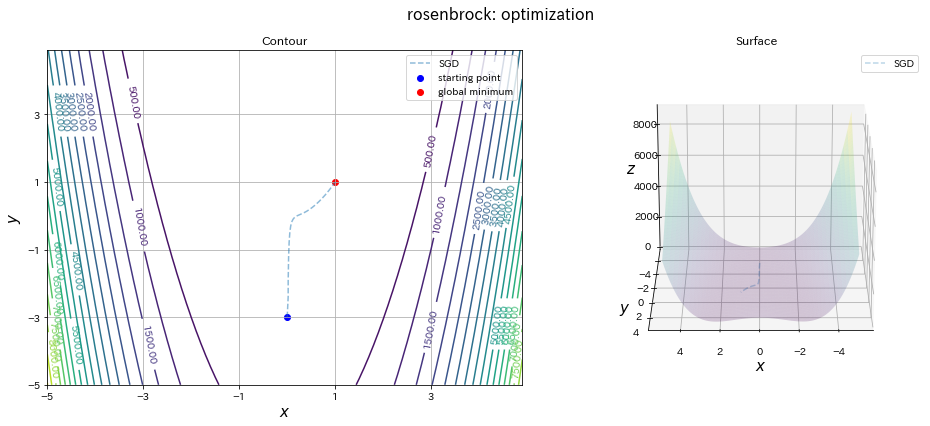

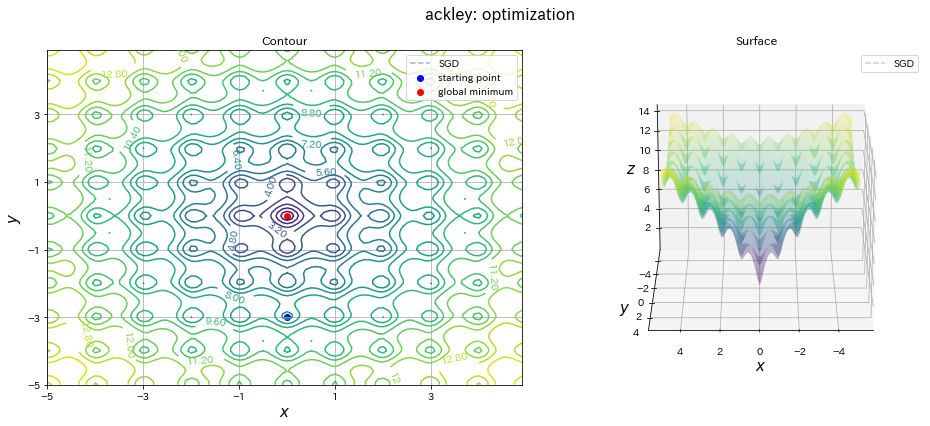

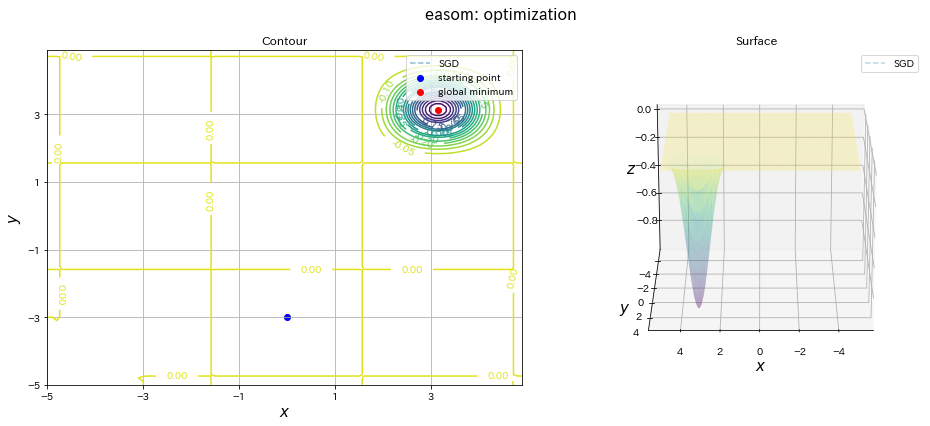

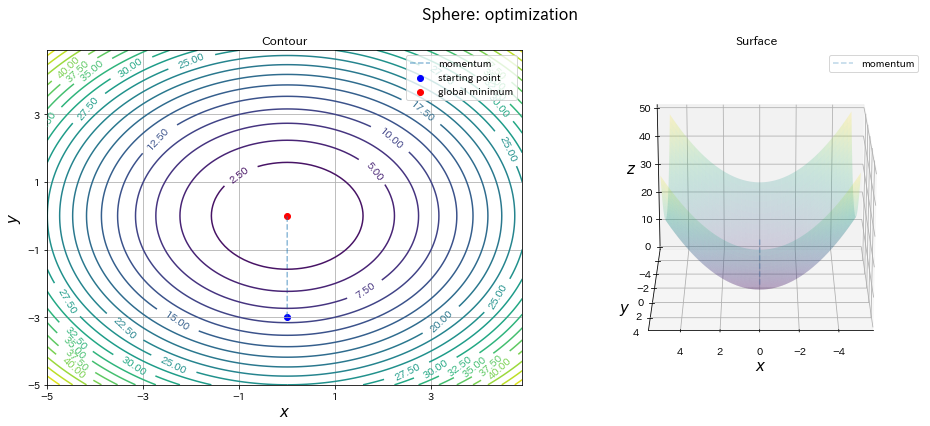

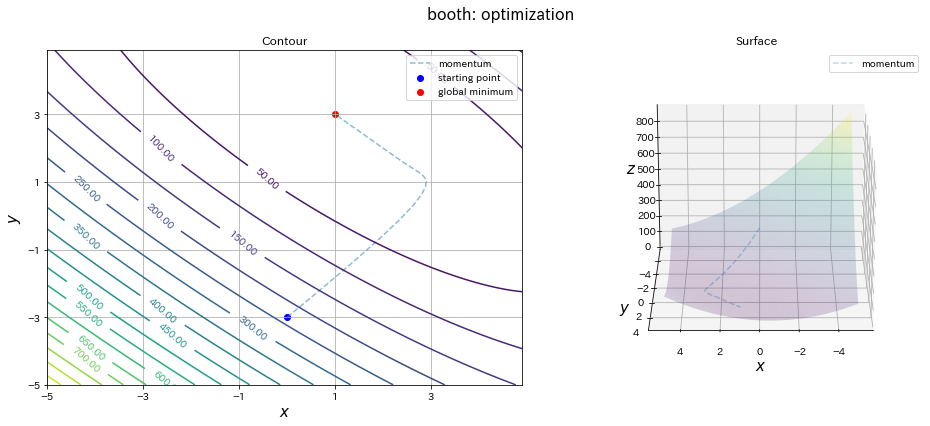

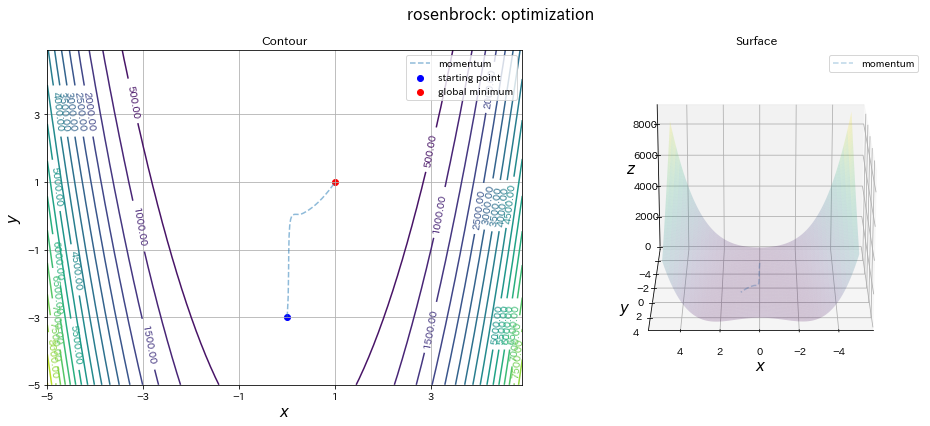

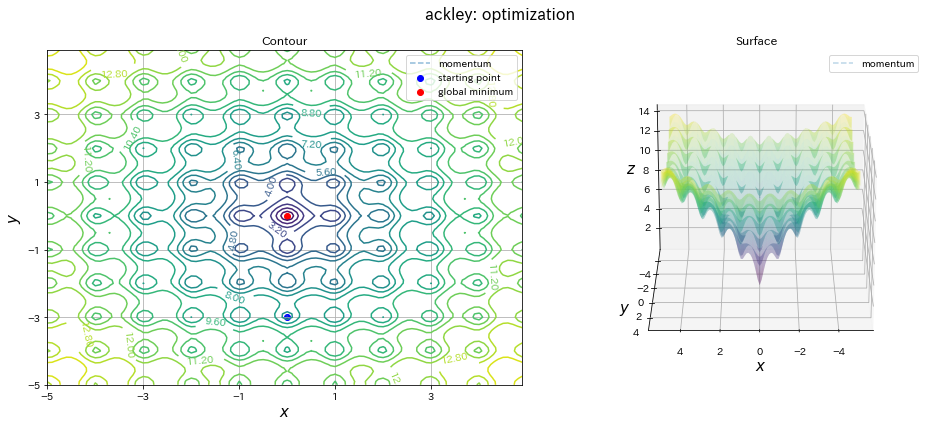

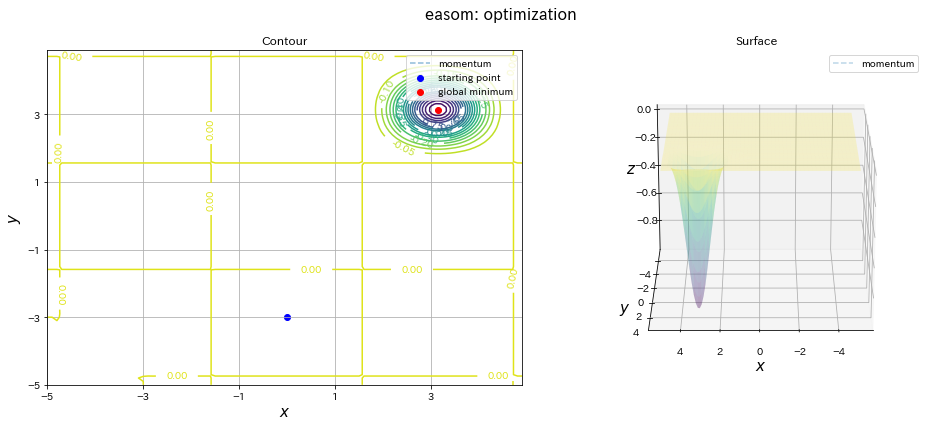

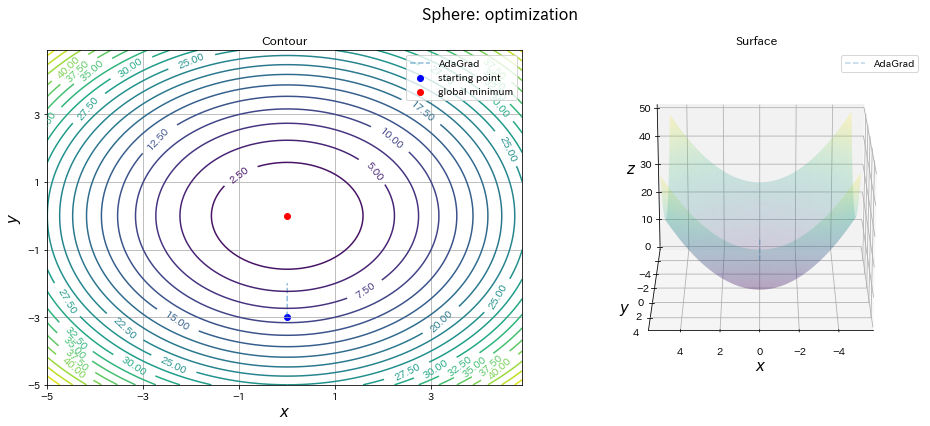

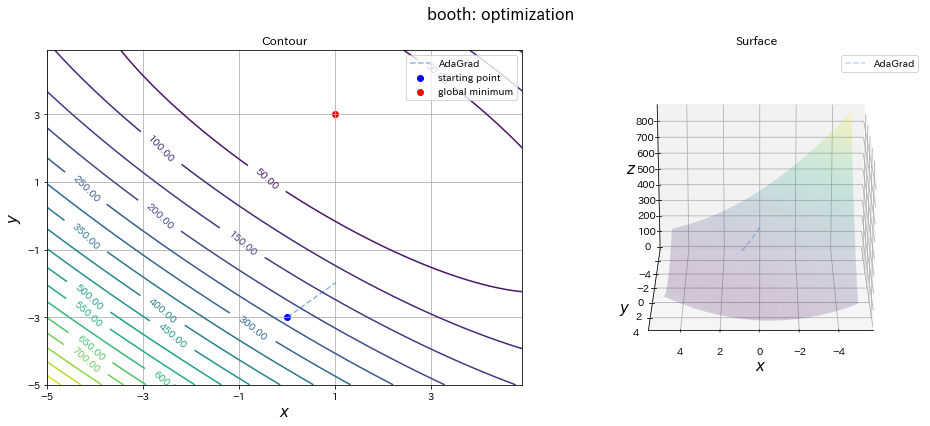

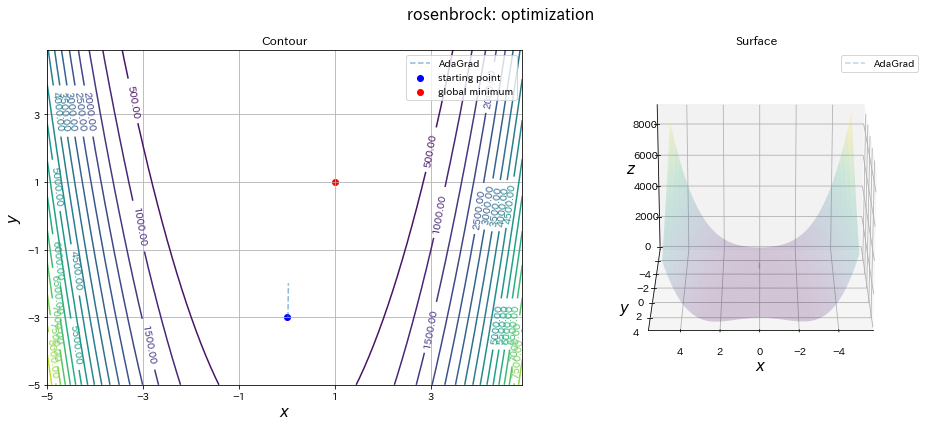

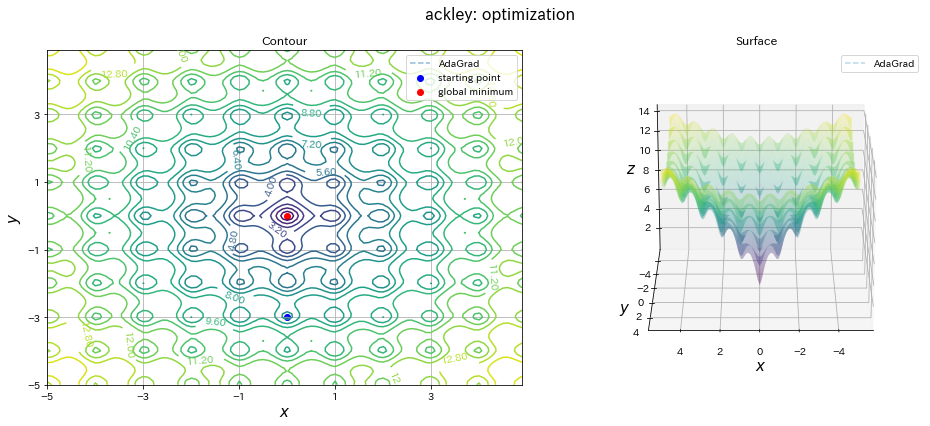

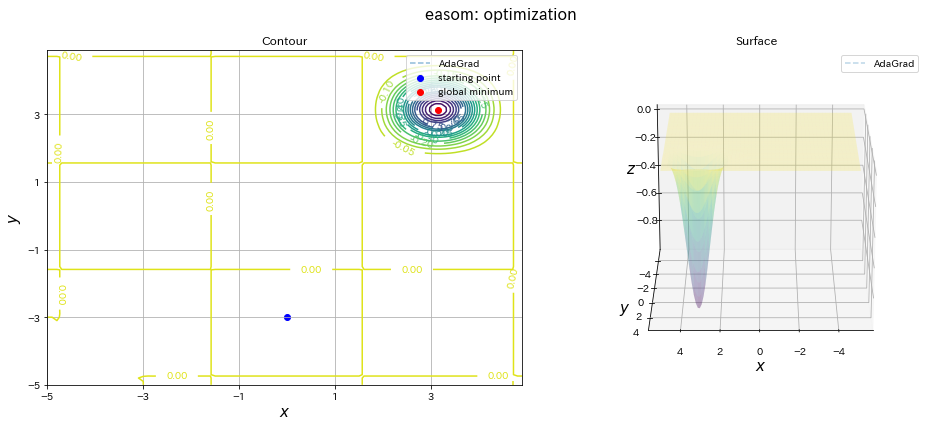

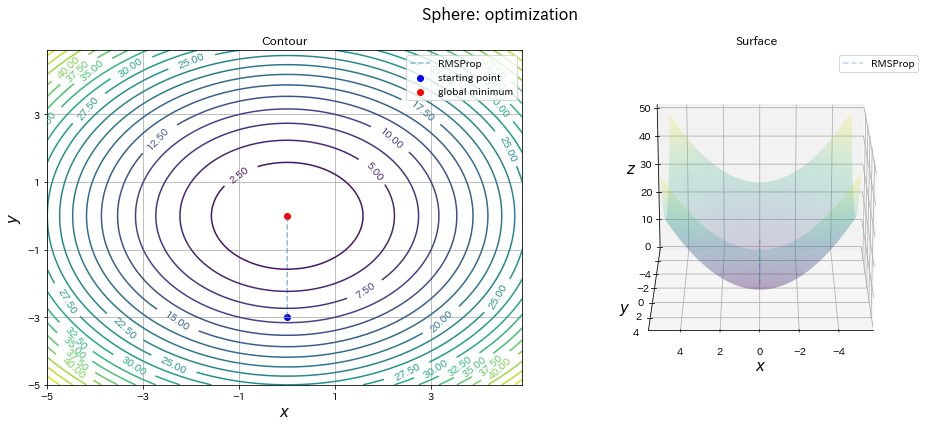

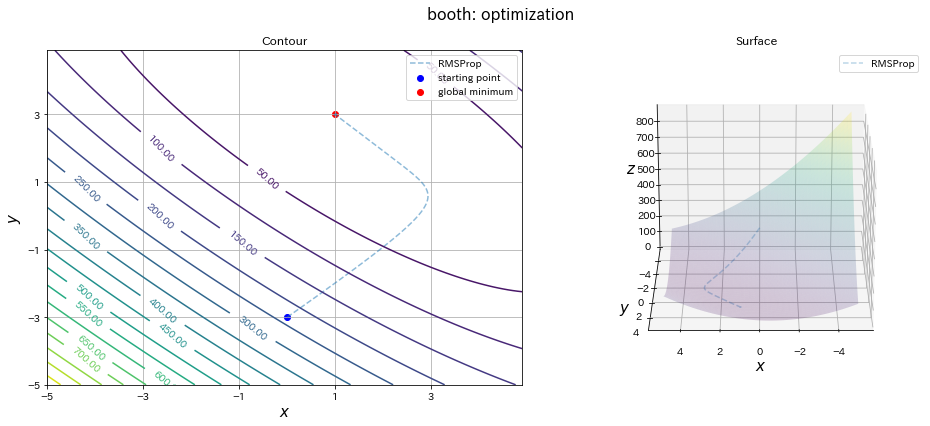

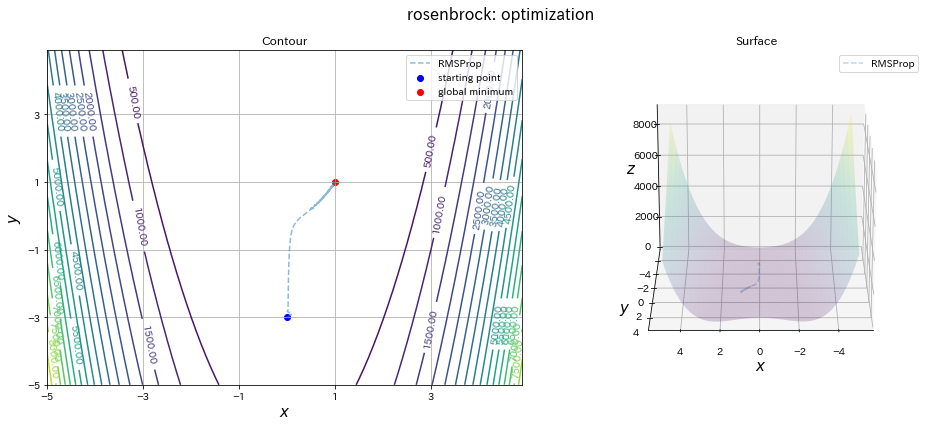

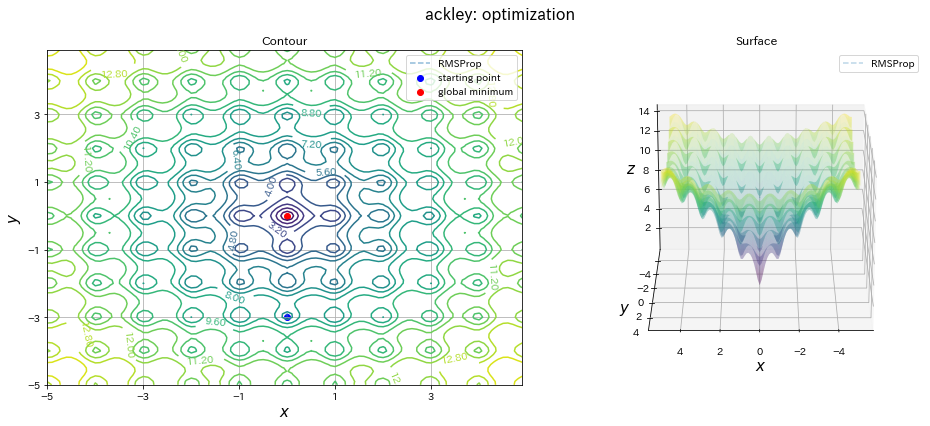

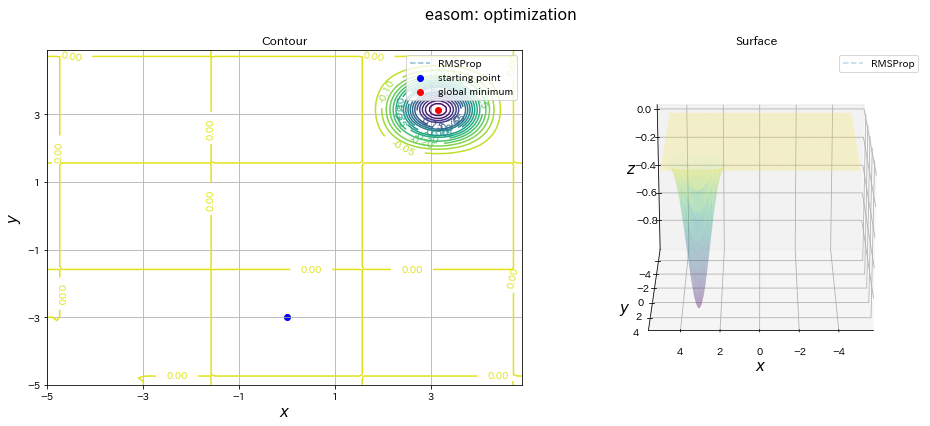

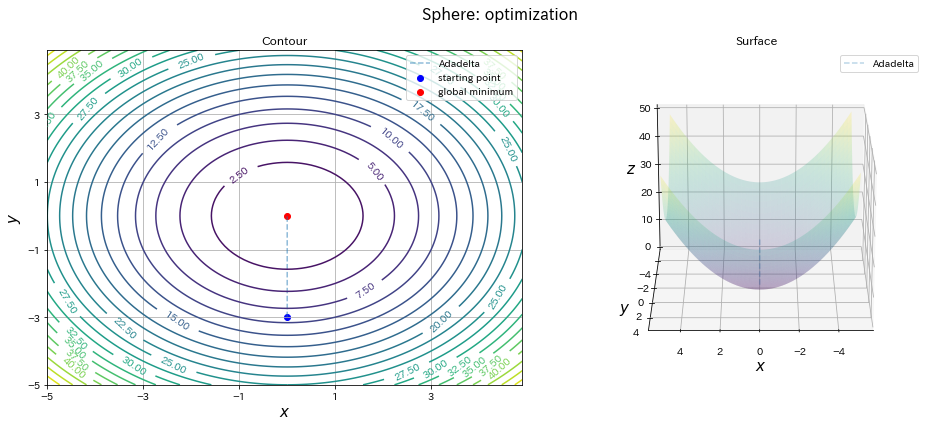

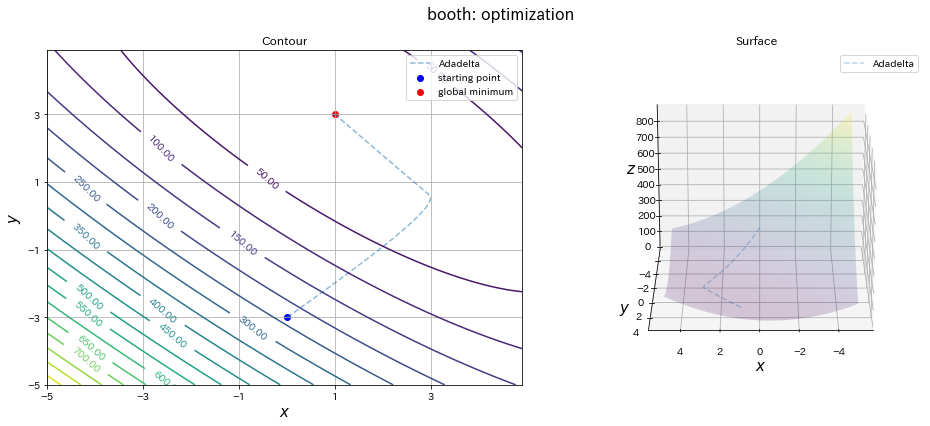

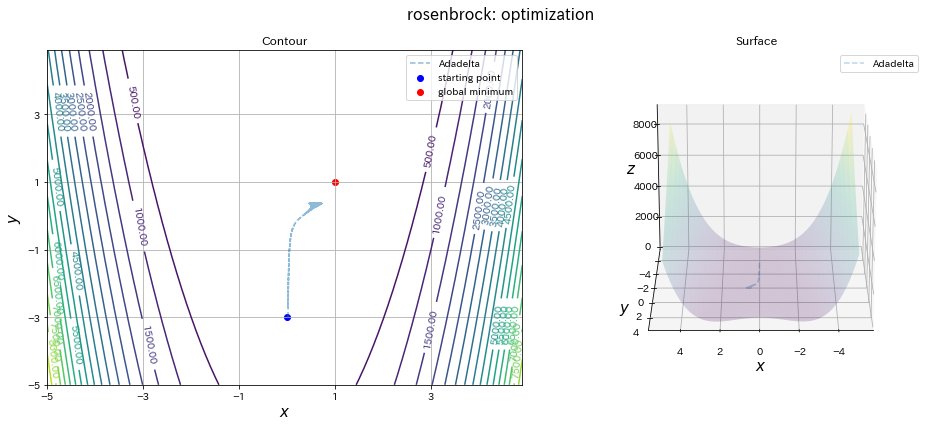

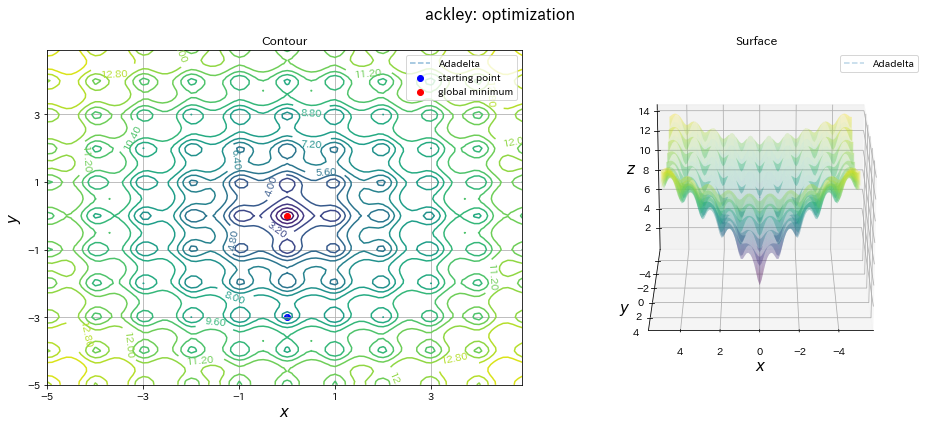

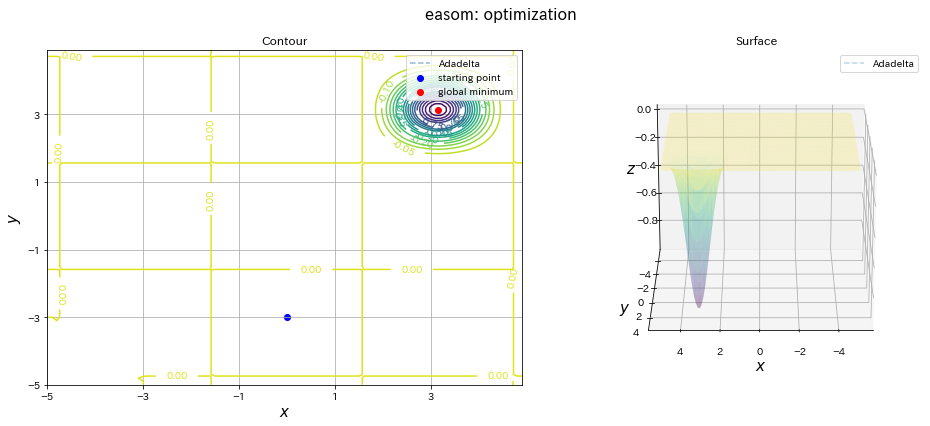

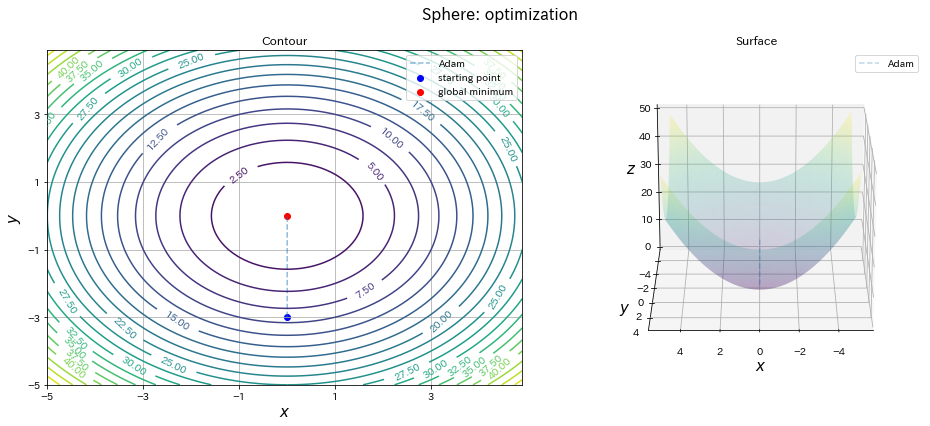

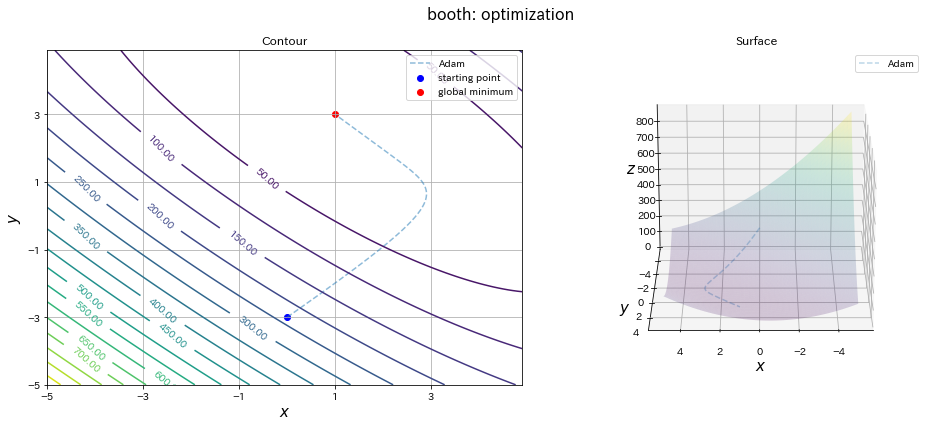

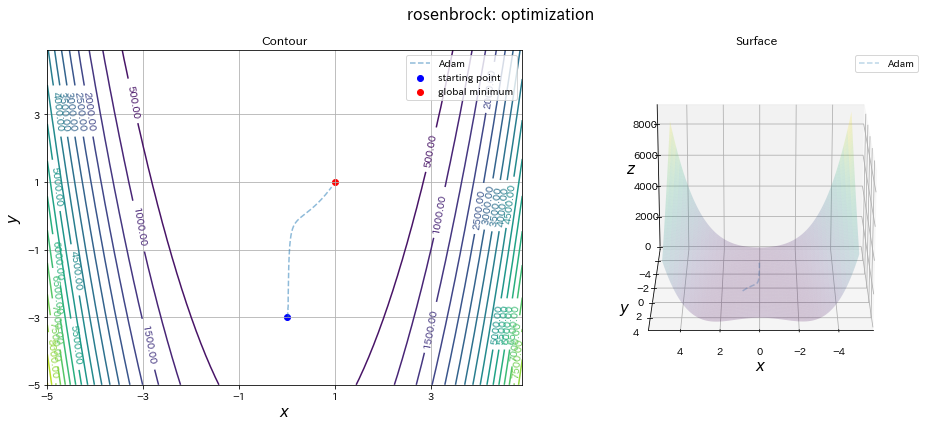

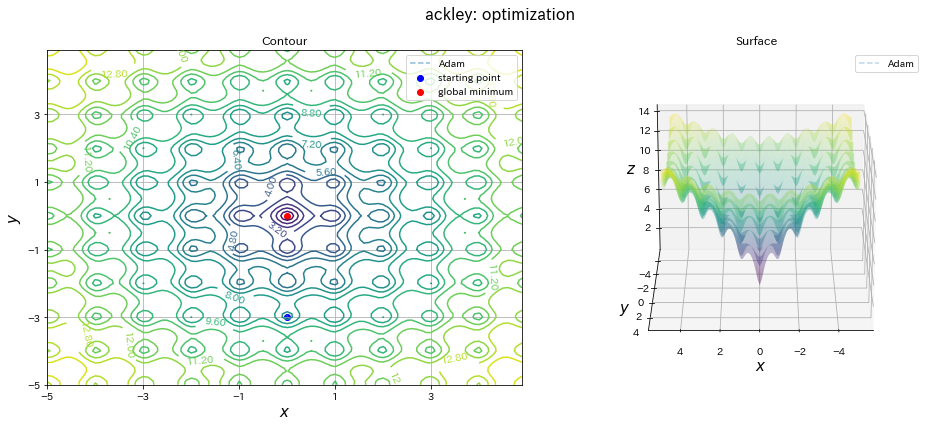

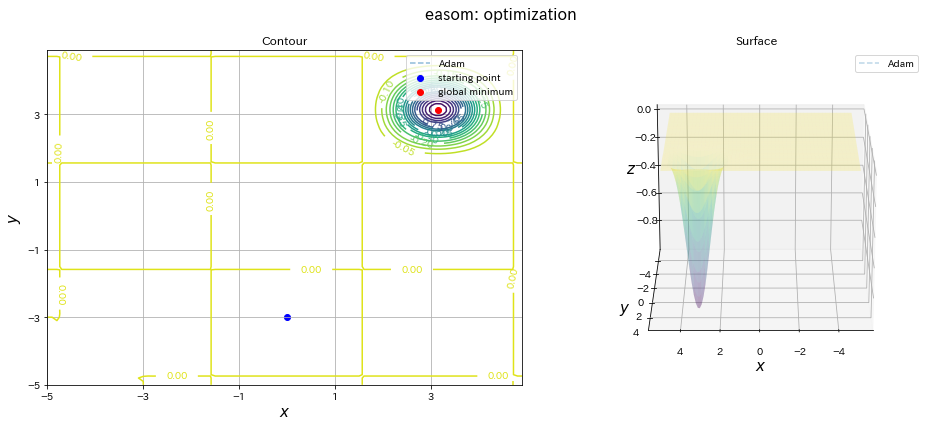

In [6]:
# plot
for optim_name in optimizers.keys():
    for func_name in functions.keys():
        plot_history(func_name,
                 functions,
                 history_res,
                 minimums,
                 initials,
                 elev=20,
                 plot_optim_name=optim_name)


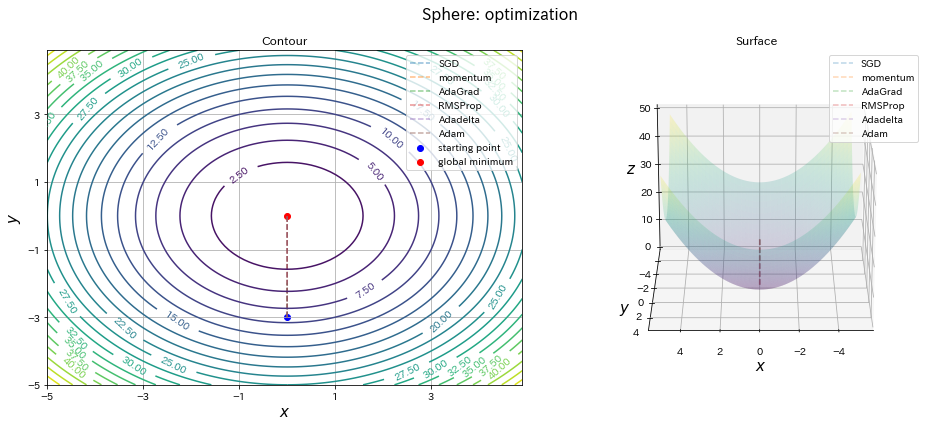

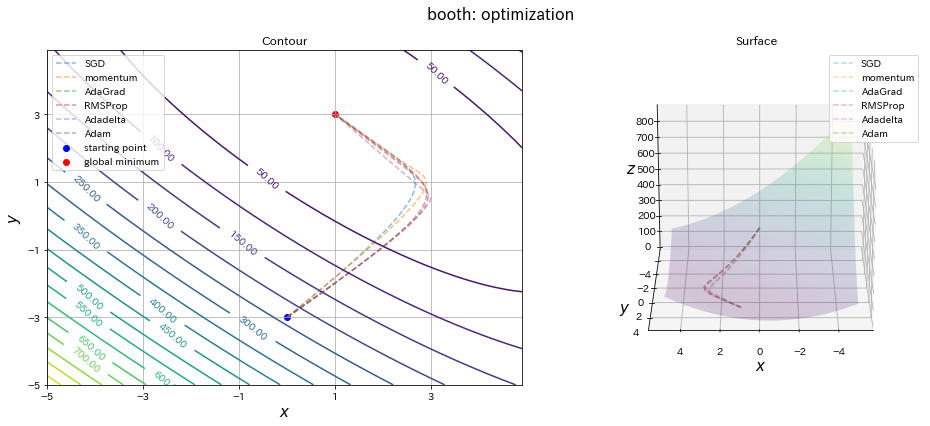

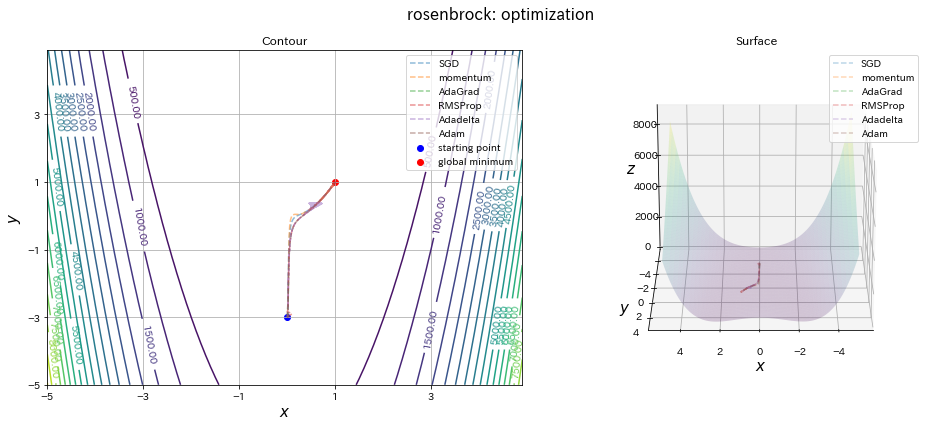

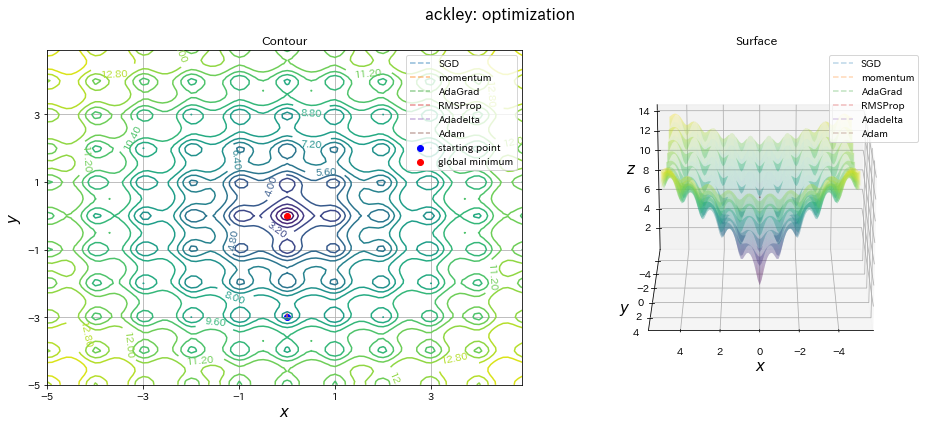

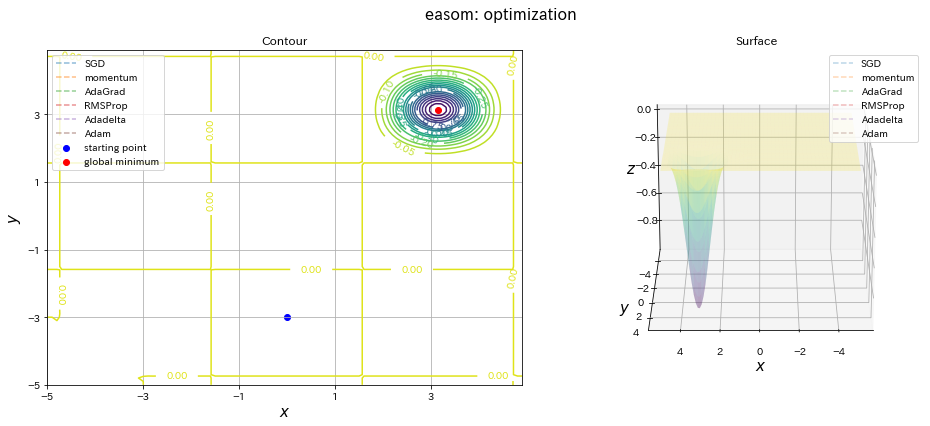

In [7]:
# plot
for func_name in functions.keys():
    plot_history(func_name, functions, history_res, minimums, initials, elev=20)

## 特徴

挙動はbooth関数・rosenbrock関数で違いが観察される。

- モメンタム: 重みの更新に前回の更新情報を一部加えることで、慣性が働くため、勾配降下法に比べて大回りして最適解へ収束
  - こうした結果は、得られた勾配情報が適切なケースで起こる。
  - 勾配降下法が谷をジグザクに渡る場合には、モメンタムはより直線的に進みやすくなるはず
  
- AdaGrad: 勾配2乗和の平方根で学習率を適応的に調整
  - 過去全期間の勾配について和を取るため、大きく更新した部分は徐々に学習されなくなってしまう。
  - 今回のようなケースだと最適解まで到達しなくなってしまう。
  - RMSPropなどが出てくる理由がわかる。
  
- RMSProp: AdaGradの改良版
  - 勾配の2乗和について、時間方向の移動平均をとったもの
  - こちらはAdaGradと異なり適切に学習が進んでいる。
  - 今回のような単純な学習ではAdaGradの良くない面が見えている。

- Adadelta: RMSPropの変種
  - RMSPropの更新の分子をパラメータの更新量の二乗移動平均にしたもの
  - 今回のケースだと、rosenbrockでうまく収束しない
  - 一度谷の山にいると、勾配情報が小さくなるので、二乗したときに学習率が大きく低下してしまう影響？

- Adam: 適応的調整にモメンタムを追加したもの
  - 今回のケースではほとんど適応的調整と違いが見えない。
  - RMSPropとモメンタムを混ぜた更新方法。今回はかなりRMSPropに近い挙動を見せている。

またどのようなアルゴリズムを使っても、以下のような関数においては大域的最適解に到達するのは非常に難しいことがわかる。
- 局所最適解が数多く存在する関数
  - そもそも非凸関数を最適化するのは難しい問題。
  - 初期値をうまく設定するか、学習率を高くする必要があると思われる。
- 勾配がほとんど消失する関数
  - 勾配に基づいて最適化するため、仕方のないタイプの問題。
  - 勾配消失問題があるNNモデルにおいて学習が進まないのは、これのイメージ。

今回の実験ではRMSProp, Adamが適当そうな手法に見える。
最適化については[こちらの論文](https://arxiv.org/pdf/1609.04747.pdf)もサマリーしていて、Adamが良いのでは？と記載があるもの、シンプルなSGDを学習率スケジューリングで行うこともよくあると記載あり。
問題に応じて適宜試すしかない？

最近は[SAM](https://arxiv.org/abs/2010.01412)という手法も提案されていて、こうした関数を使うと非凸関数でもうまくいく可能性はありそう。